In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #visualization
import plotly.express as px
import seaborn as sns #visualization
from plotly.offline import init_notebook_mode, iplot, plot

Import Data

In [ ]:
df = pd.read_csv('/content/sample_data/songs_normalize.csv')
#df.head()

## **Preprocessing data**

The data set doesn't have any null values.
It has some duplicate entries that will be removed.

Also we can convert the songs duration to seconds for better readibilty.

In [ ]:
df = df.drop_duplicates() # keep first duplicate row
df["duration_s"] = df.duration_ms.apply(lambda x : round(x/1000)) # add durartion in seconds
df.drop("duration_ms", axis=1, inplace=True) #remove duration in ms

In [ ]:

#Top Hits by Year
songs_per_years = df['year'].value_counts().sort_index()

iplot(px.bar(songs_per_years, 
       title='Songs per year', 
       text_auto='.2s',
       labels=dict(index='year',value='number of songs'),
       color_discrete_sequence=['#0055FF']
      ).update_xaxes(type='category'))


Since the years 1998, 1999 and 2020 have few examples, we will be removing songs from those years.
Also, we considered that the song **title** won't have any correlation with its popularity, so that column will be removed.


```
# This is formatted as code
```



In [ ]:
df = df[(df.year >= 2000) & (df.year <= 2019)] 
df = df.drop(['song'], axis = 1) #removing song title column
#df.head()


In [ ]:
#df.info()

## Popularity classification
First let's analise the popularity distribution, and try to indentify existing outliers 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9c96f2390>]],
      dtype=object)

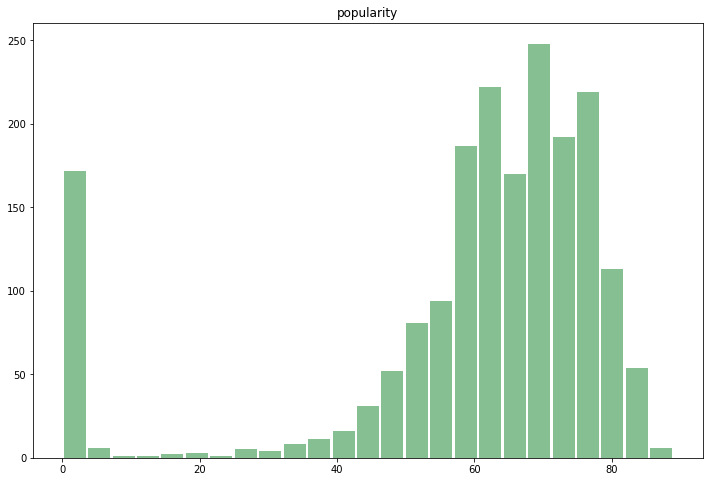

In [ ]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)


#### Removing entries 
While analising the histogram, we found strange that a lot of songs had the popularity equal to zero. 
After loooking through the data, we noticed that that most of those songs were undoubtedly misclassified. For example, songs like Hello by Adele, or Despacito by Luis Fonsi, among others, were classified with zero popularity even though they are known songs for beating selling and streaming records.

In [ ]:
df = df[(df.popularity > 5)] 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9ca45a090>]],
      dtype=object)

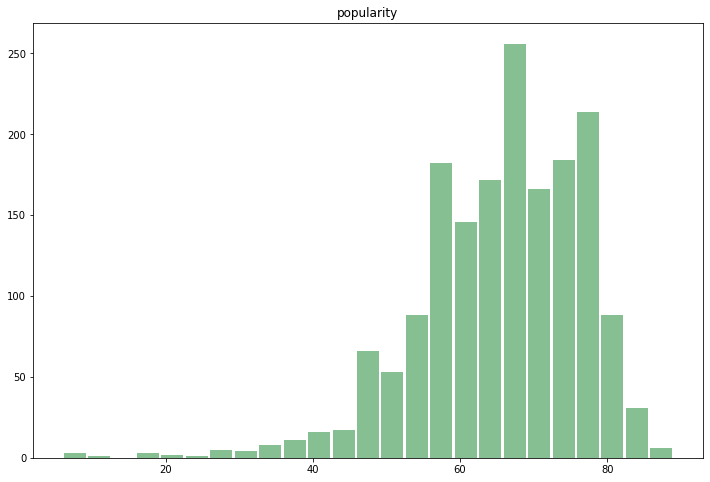

In [ ]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

### Discretization 
- 11-62 not popular
- 62-72 semi-popular
- 72-89 popular

[ 6. 62. 72. 89.]


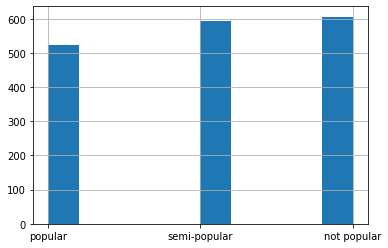

In [ ]:
pop, bins = pd.qcut(df.popularity, 3, labels=["not popular", "semi-popular", "popular"], retbins = True)
print(bins)
pop.hist()

Adding the new class, **popularity_class**, based on popularity values

In [ ]:
conditions = [
    (df['popularity'] <= 62),
    (df['popularity'] > 62) & (df['popularity'] <= 72),
    (df['popularity'] > 72)
    ]

labels = ["not popular", "semi-popular", "popular"]

#creating a new column
df['popularity_class'] = np.select(conditions, labels)


In [ ]:
df.head()

,artist,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,duration_s,popularity_class
0,Britney Spears,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop,211,popular
3,Bon Jovi,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal",224,popular
4,*NSYNC,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop,201,semi-popular
6,Eminem,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.504,hip hop,284,popular
7,Robbie Williams,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.0267,0.000000,0.4670,0.861,103.035,"pop, rock",259,semi-popular



#### Pairplot
Para nos ajudar a ver possíveis erros nos dados, e se existe alguma correlação óbvia entre as diferentes colunas

In [ ]:
df['popularity_class'].unique()
num_var= ['year', 'danceability', 'energy', 'key','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']

#sns.pairplot(df, hue = 'popularity_class', vars= num_var)

## Análise exploratória

- Como é que os dados estão distribuídos
- Existem correlações nos dados, e o porquê de estas existirem

Para verificar possíveis correlações vamos usar um heatmap

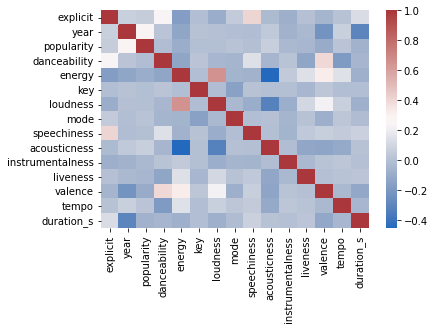

In [ ]:
# Correlation between features
corr = df.corr()
#Heatmap
sns.heatmap(corr, cmap="vlag")


Observando o mapa, verificamos algumas correlações positivas entre:
- Loudness e Energy - quanto mais alta a música mais energia tem
- Valence e Danceability - músicas mais positivas tendem a ser mais dançáveis

Correlações negativas:
- Energy and Acousticness - músicas acústicas têm menos energia
- Year and Duration - ao longo dos anos as músicas tendem a ser mais curtas

## Classificação

Dividir os dados em dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

#all colums except popularity and popularity_class
cols = (df.columns.values.tolist())
cols.remove('popularity')
cols.remove('popularity_class')
cols.remove('artist')
cols.remove('genre')
#all inputs
inputs =df[cols].values

#all popularity_class labels
all_labels = df['popularity_class'].values

inputs[:3]

array([[False, 2000, 0.751, 0.834, 1, -5.444, 0, 0.0437, 0.3, 1.77e-05,
        0.355, 0.894, 95.053, 211],
       [False, 2000, 0.551, 0.913, 0, -4.063, 0, 0.0466, 0.0263,
        1.35e-05, 0.347, 0.544, 119.992, 224],
       [False, 2000, 0.614, 0.928, 8, -4.806, 0, 0.0516, 0.0408, 0.00104,
        0.0845, 0.879, 172.656, 201]], dtype=object)

Agora os dados estão prontos a ser divididos

In [ ]:
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(inputs, all_labels, test_size=0.25, random_state=1)

## Decision Tree
Para já vamos usar um classificador básico, ou seja, sem nenhuns ajustes nos parâmetros

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
dt_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
dt_classifier.score(testing_inputs, testing_classes)

0.3805104408352668